
**Project 1: Gradient-based Algorithms and Differentiable Programming**

1. Introduction:\
Consider a simple formulation of rocket landing where the rocket state $x(t)$ is represented by its distance to the ground $d(t)$ and its velocity $v(t)$, i.e., $x(t) = [d(t), v(t)]^T$, where $t$ specifies time. The control input of the rocket is its acceleration $a(t)$. The discrete-time dynamics follows

$$
\begin{aligned}
d(t+1) = d(t) + v(t) \Delta t, \\
v(t+1) = v(t) + a(t) \Delta t,
\end{aligned}
$$
where $\Delta t$ is a time interval. Further, let the closed-loop controller be

$$
a(t) = f_{\theta}(x(t))
$$
where $f_{\theta}(\cdot)$ is a neural network with parameters $\theta$, which are to be determined through optimization.

For each time step, we assign a loss as a function of the control input and the state: $l(x(t),a(t))$. In this example, we will simply set $l(x(t),a(t))=0$ for all $t=1,...,T-1$, where $T$ is the final time step, and $l(x(T),a(T)) = ||x(T)||^2 = d(T)^2 + v(T)^2$. This loss encourages the rocket to reach $d(T)=0$ and $v(T)=0$, which are proper landing conditions.

The optimization problem is now formulated as

$$
\begin{aligned}
\min_{\theta} \quad &amp; ||x(T)||^2 \\
\quad &amp; d(t+1) = d(t) + v(t) \Delta t, \\
\quad &amp; v(t+1) = v(t) + a(t) \Delta t, \\
\quad &amp; a(t) = f_{\theta}(x(t)), ~\forall t=1,...,T-1
\end{aligned}
$$
While this problem is constrained, it is easy to see that the objective function can be expressed as a function of $x(T-1) and a(T-1)$, where $x(T-1)$ as a function of $x(T-2)$ and $a(T-2)$, and so on. Thus it is essentially an unconstrained problem with respect to $\theta$.

In the following, we code this problem up with PyTorch, which allows us to only build the forward pass of the loss (i.e., how we move from $x(1)$ to $x(2)$ and all the way to $x(T)$) and automatically get the gradient $\nabla_{\theta} l(x(T),a(T))$.


**Desciption:**


$$
\begin{aligned}
\min_{\theta} \quad &amp; \mathbb{E}_{\{w(t), u(t), x(0)\}} ||(x(T),y(T),x_v(T),y_v(T),{\theta}(T),{\theta}_v(T))||^2  \\
=\\
\min_{\theta} \quad &amp; ||(h(T))||^2  \\
\end{aligned}
$$


$$
\begin{aligned}
\quad &amp; x(t+1) = x(t) + V_x(t) \Delta t, \\
\quad &amp; y(t+1) = x(t) + V_y(t) \Delta t, \\
\quad &amp; V_x(t+1) = V_x(t) + a_x(t) \Delta t + w(t) \Delta t, \\
\quad &amp; V_y(t+1) = V_y(t) + a_y(t) \Delta t + u(t) \Delta t, \\
\quad &amp; a_x(t+1) = f_{\theta}(h(t)), ~\forall t=1,...,T-1, \\
\quad &amp; a_y(t+1) = -g + f_{\theta}(h(t)), ~\forall t=1,...,T-1, \\
\quad &amp; {\theta}(t+1) = {\theta}(t) + V_{\theta}(t) \Delta t, \\
\end{aligned}
$$



In [ ]:
# overhead

import logging
import math
import random
import numpy as np
import time
import torch as t
import torch.nn as nn
from torch import optim
from torch.nn import utils
import matplotlib.pyplot as plt

logger = logging.getLogger(__name__)


# environment parameters

FRAME_TIME = 0.005  # time interval
GRAVITY_ACCEL = 9.81  # gravity constant
BOOST_ACCEL = 15  # thrust constant
ROTATION_ACCEL = 65*math.pi/180

In [ ]:
# define system dynamics
class Dynamics(nn.Module):

    def __init__(self):
        super(Dynamics, self).__init__()

    @staticmethod
    def forward(state, action):

        """
        action[0] = Thrust in y
        action[1] = Thrust in x
        action[2] = Rotational thrust

        state[0] = y
        state[1] = y_vel
        state[2] = x
        state[3] = x_vel
        state[4] = orientation
        state[5] = rot_vel
        """
        
        # Apply gravity
        delta_state_gravity = t.tensor([0., GRAVITY_ACCEL * FRAME_TIME, 0., 0.,0.,0.])


        delta_state_y = BOOST_ACCEL * FRAME_TIME * t.tensor([0., -1., 0., 0.,0.,0.]) * action[0] 
        
        delta_state_x = BOOST_ACCEL * FRAME_TIME * t.tensor([0.,0., 0., 1.,0.,0.]) * action[1]  

        delta_state_rotation = ROTATION_ACCEL * FRAME_TIME * t.tensor([0., 0., 0., 0., 0., 1.]) * action[2]

        redundancy_var = delta_state_y

        #Drag
        """
          We know that Drag force is given by the formula: Df= (Co-eff of Drag * Denisty of material * Area * Velocity^2)/2
          Assumptions: Taking GSLV Mk III [ISRO:- Indian Space Research Organisation]
          Co-efficient of Drag =  0.295 //taken from internet
          Area = 1.6*1.6*pi = 8.0457
          Density = 4420 kg/m^3
          mass= 3,22,379 Kg (Chandrayan Indian Project)

          Drag Force = 0.5 * 0.295 * 8.0457 * 4420 * vel^2 
          Drag Force = 5245.394 * Vel^2


          Rev Acceleration due to Drag =  Drag_Force/ mass = 0.01627 * Vel^2
        """

        DRAG_DECEL = 0.01627 * redundancy_var * redundancy_var

        NET_ACCEL = BOOST_ACCEL - DRAG_DECEL

        delta_state_yn = NET_ACCEL * FRAME_TIME * t.tensor([0., -1, 0., 0.,0.,0.]) * action[0] 


        state = state + delta_state_yn + delta_state_x + delta_state_rotation + delta_state_gravity

        step_mat = t.tensor([[1., FRAME_TIME, 0., 0., 0., 0.],
                            [0., 1., 0., 0., 0., 0.],
                            [0., 0., 1., FRAME_TIME, 0., 0.],
                            [0., 0., 0., 1., 0., 0.],
                            [0., 0., 0., 0., 1., FRAME_TIME],
                            [0., 0., 0., 0., 0., 1.]])
        state = t.matmul(step_mat, state)

        return state 
      

In [ ]:
class Controller(nn.Module):

    def __init__(self, dim_input, dim_hidden, dim_output):
        """
        dim_input: # of system states
        dim_output: # of actions
        dim_hidden: up to you
        """
        super(Controller, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(dim_input, dim_hidden),
            nn.Tanh(),
            nn.Linear(dim_hidden, dim_hidden),
            nn.Tanh(),
            nn.Linear(dim_hidden, dim_output),
            # You can add more layers here
            nn.Sigmoid()
        )

    def forward(self, state):
        action = self.network(state)
        return action

In [ ]:
class Simulation(nn.Module):

    def __init__(self, controller, dynamics, T):
        super(Simulation, self).__init__()
        self.state = self.initialize_state()
        self.controller = controller
        self.dynamics = dynamics
        self.T = T
        self.action_trajectory = []
        self.state_trajectory = []

    def forward(self, state):
        self.action_trajectory = []
        self.state_trajectory = []
        for _ in range(T):
            action = self.controller.forward(state)
            state = self.dynamics.forward(state, action)
            self.action_trajectory.append(action)
            self.state_trajectory.append(state)
        return self.error(state)

    @staticmethod
    def initialize_state():
                state = [10., 0., 5., 0.,0.,0.]  # TODO: need batch of initial states
                return t.tensor(state, requires_grad=False).float()

    def error(self, state):
      loss = t.sum(t.square(state))
      return loss

In [ ]:
class Optimize:
    def __init__(self, simulation):
        self.simulation = simulation
        self.parameters = simulation.controller.parameters()
        self.optimizer = optim.LBFGS(self.parameters, lr=0.01)

    def step(self):
        def closure():
            loss = self.simulation(self.simulation.state)
            self.optimizer.zero_grad()
            loss.backward()
            return loss
        self.optimizer.step(closure)
        return closure()
    
    def train(self, epochs):
        for epoch in range(epochs):
            loss = self.step()
            print('- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -')
            print('[%d] loss: %.3f' % (epoch + 1, loss))
            self.visualize()

    def visualize(self):
    # Establishing data arrays to plot
        statedata = np.array([self.simulation.state_trajectory[i].detach().numpy() for i in range(self.simulation.T)])
        actiondata = np.array([self.simulation.action_trajectory[i].detach().numpy() for i in range(self.simulation.T)])
        Time = FRAME_TIME * np.linspace(0,T,T)
        x = statedata[:, 0]
        xdot = statedata[:, 1]
        y = statedata[:, 2]
        ydot = statedata[:, 3]
        rot = statedata[:, 4]
        rotdot = statedata[:, 5]
        thrust = actiondata[:, 0]
        rotthrust = actiondata[:,1]
      
        # Creating the plot for each of the state variables
        f1 = plt.figure()
        ax1 = f1.add_subplot(111)
        ax1.plot(Time, y, label = 'y position')
        ax1.plot(Time, ydot, label = 'ydot')
        ax1.plot(Time, x, label = 'x position')
        ax1.plot(Time, xdot, label = 'xdot')
        ax1.plot(Time, rot, label = 'rot')
        ax1.plot(Time, rotdot, label = 'rotdot')
        plt.xlabel('Time, s')
        plt.ylabel('State Variables')
        plt.title('State Variables vs. Time')
        plt.grid(True)
        ax1.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
      
        # Creating the plot for each of the action variables
        f2 = plt.figure()
        ax2 = f2.add_subplot(111)
        ax2.plot(Time, thrust, label = 'thrust')
        ax2.plot(Time, rotthrust, label = 'rotthrust')
        plt.xlabel('Time, s')
        plt.ylabel('Action Variables')
        plt.title('Action Variables vs. Time')
        plt.grid(True)
        ax2.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
      
        plt.show()

- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
[1] loss: 132.471


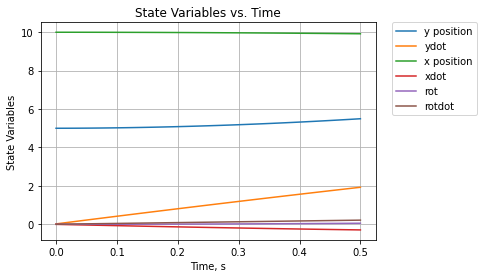

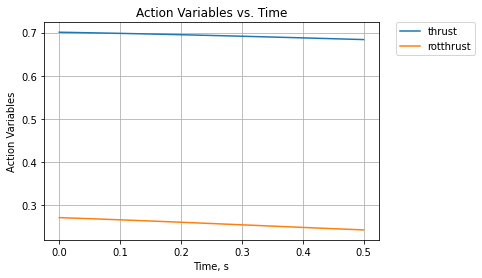

- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
[2] loss: 126.442


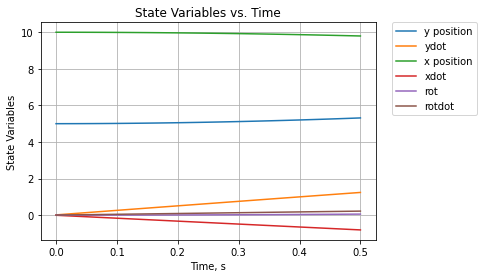

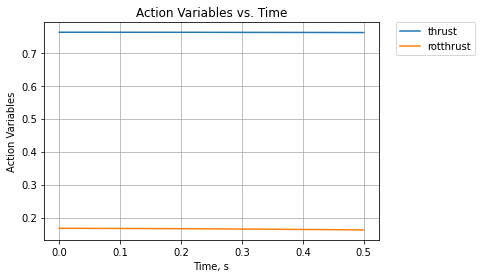

- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
[3] loss: 123.353


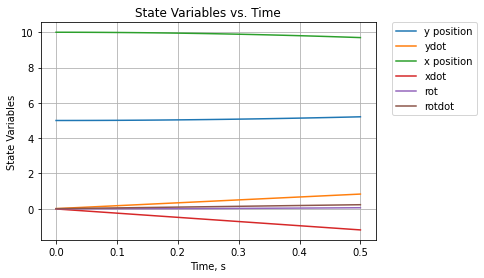

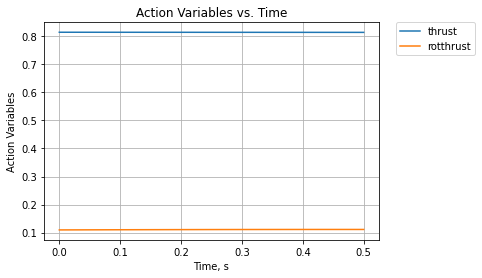

- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
[4] loss: 122.032


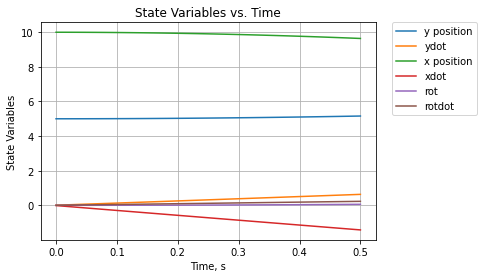

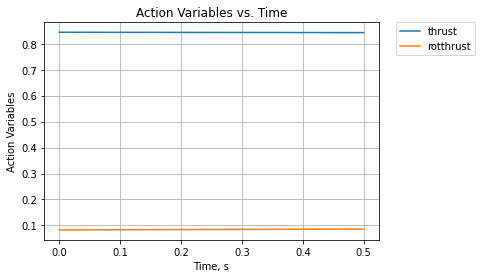

- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
[5] loss: 121.271


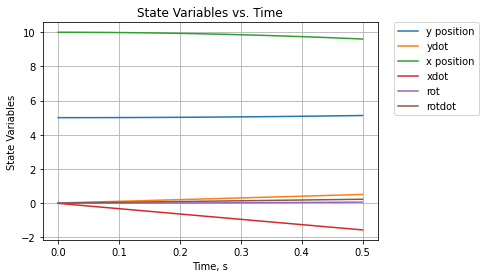

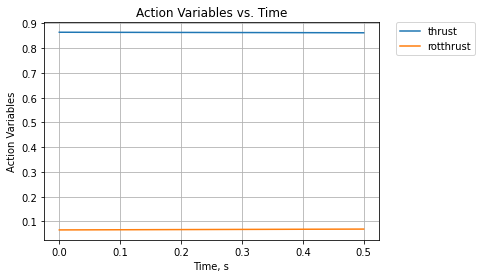

- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
[6] loss: 120.578


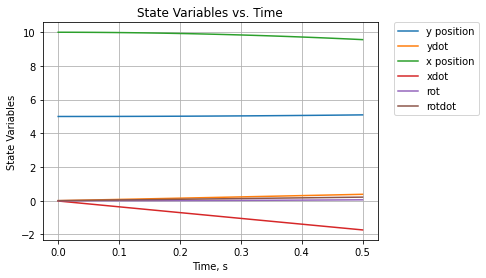

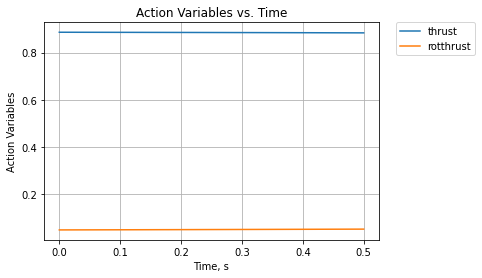

- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
[7] loss: 119.873


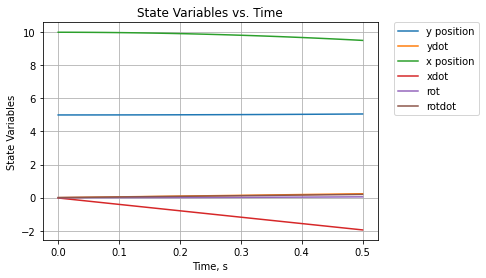

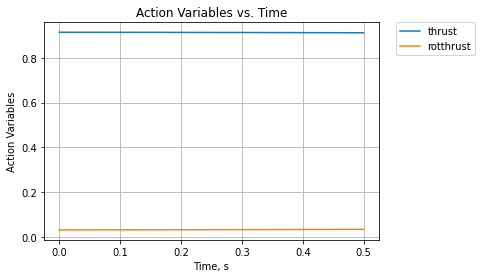

- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
[8] loss: 119.564


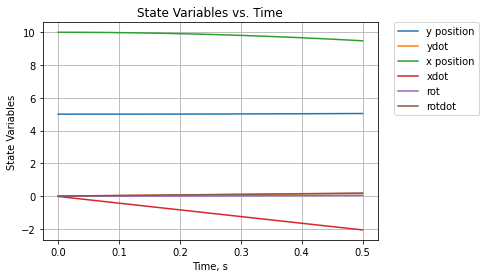

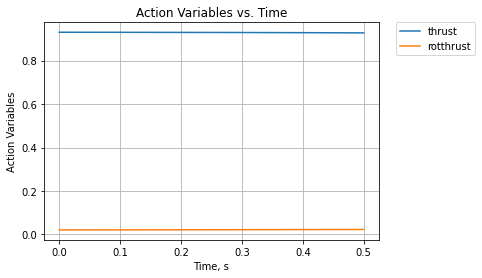

- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
[9] loss: 119.255


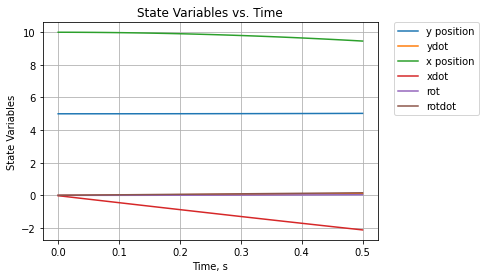

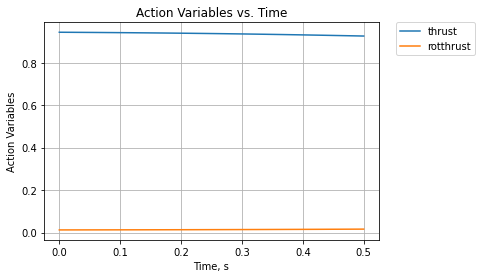

- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
[10] loss: 117.900


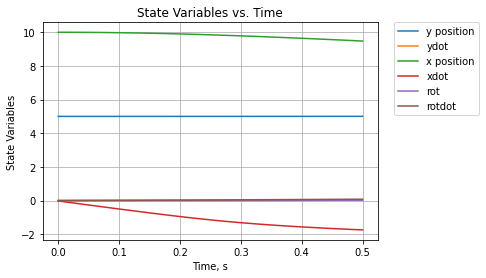

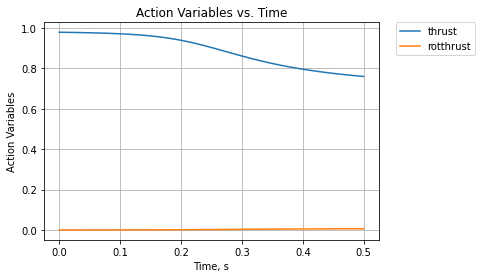

- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
[11] loss: 117.272


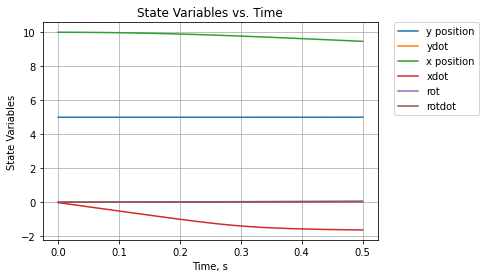

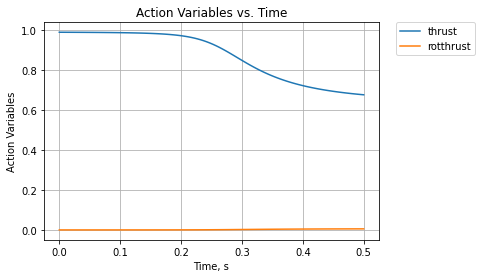

- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
[12] loss: 117.040


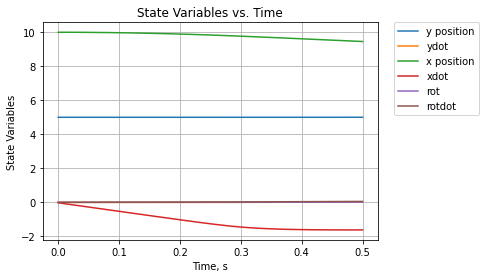

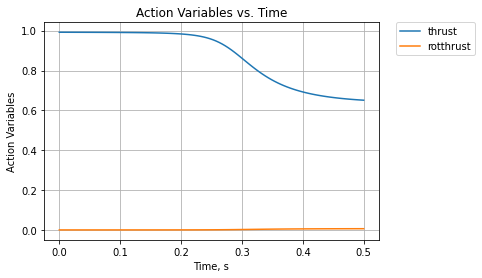

- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
[13] loss: 116.905


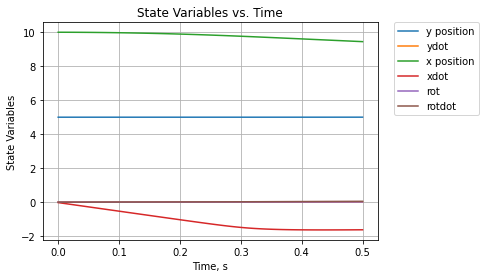

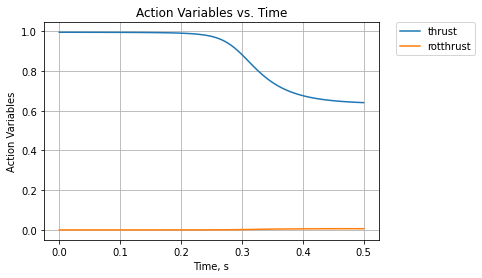

- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
[14] loss: 116.814


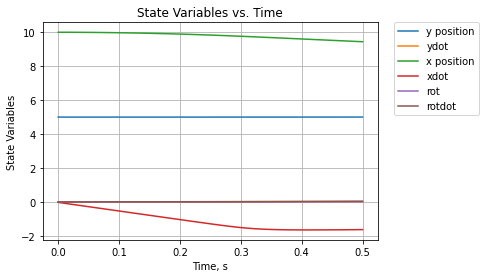

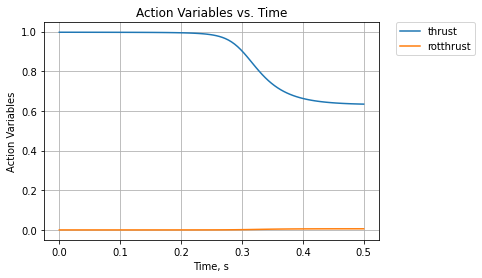

- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
[15] loss: 116.724


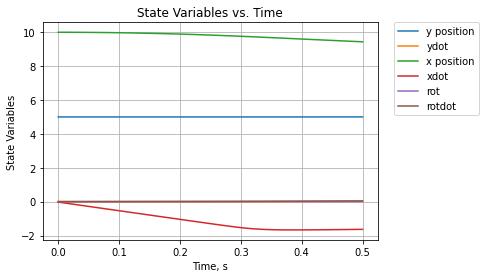

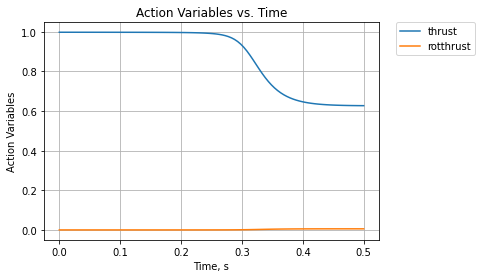

- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
[16] loss: 116.659


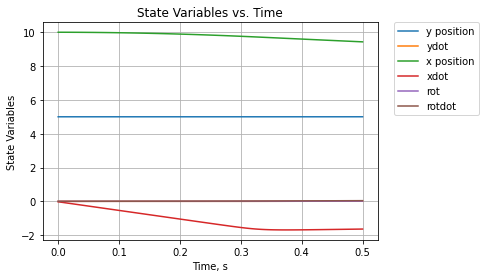

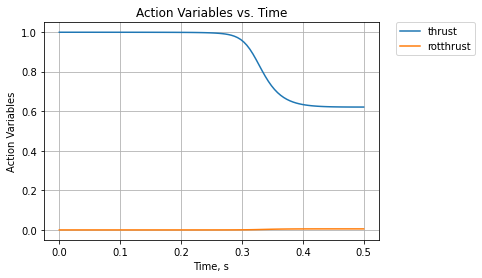

- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
[17] loss: 116.319


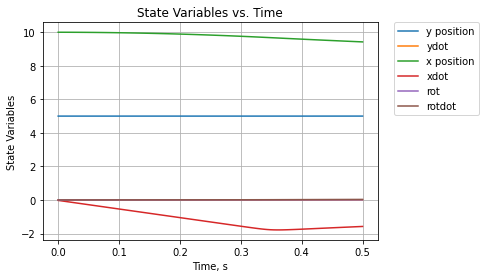

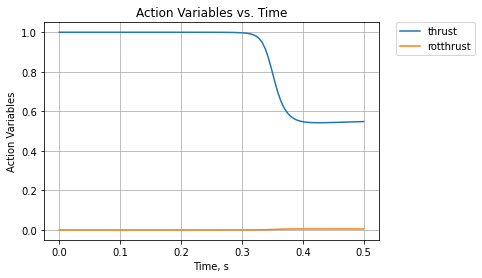

- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
[18] loss: 115.389


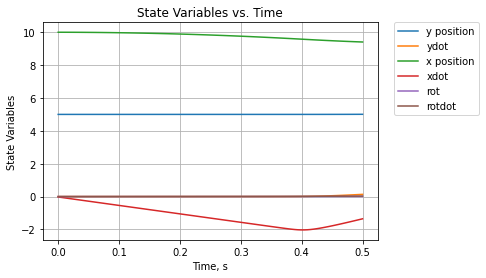

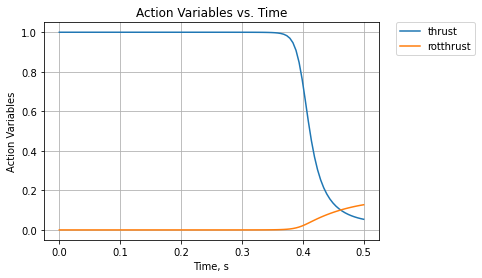

- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
[19] loss: 115.300


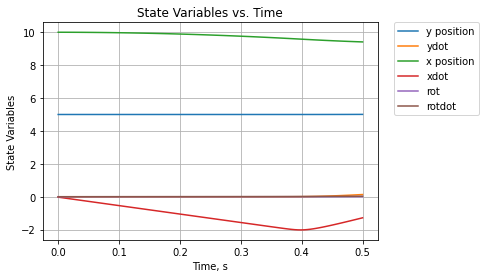

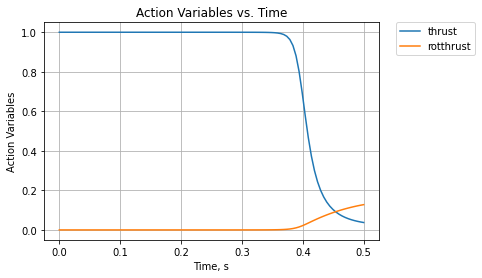

- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
[20] loss: 115.228


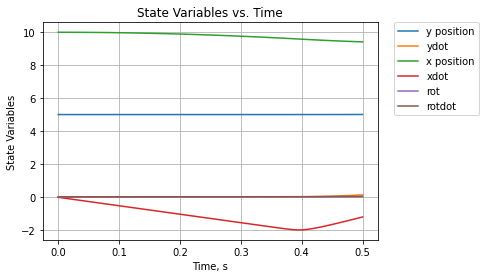

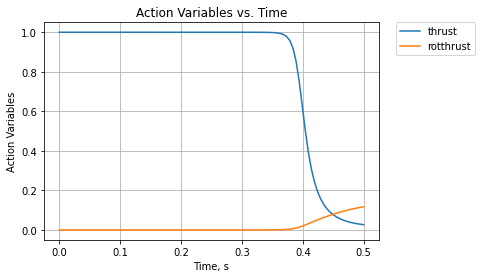

- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
[21] loss: 115.174


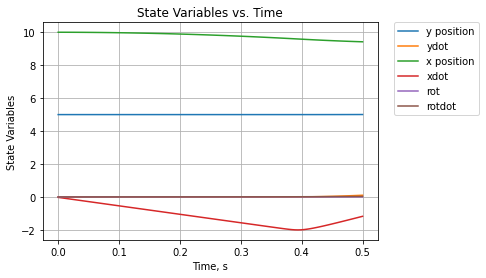

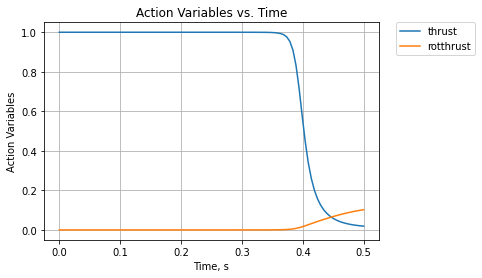

- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
[22] loss: 115.136


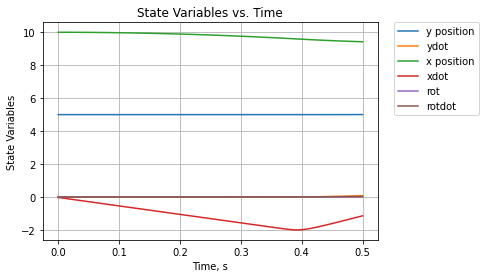

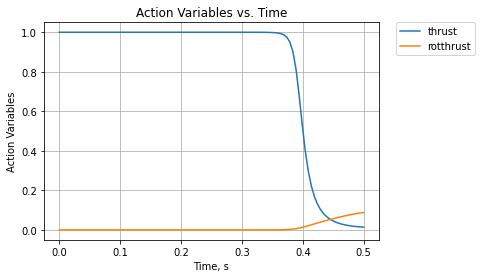

- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
[23] loss: 115.108


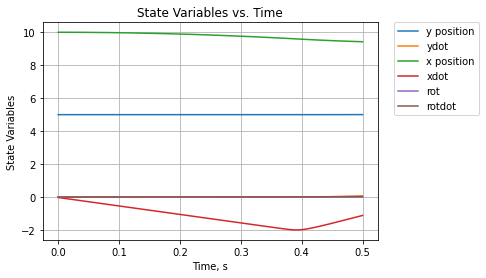

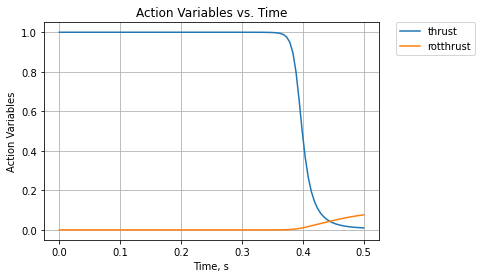

- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
[24] loss: 115.087


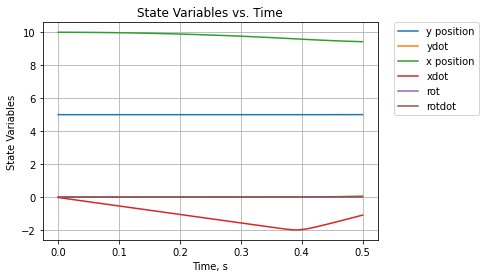

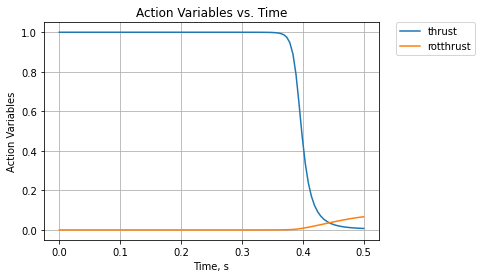

- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
[25] loss: 115.072


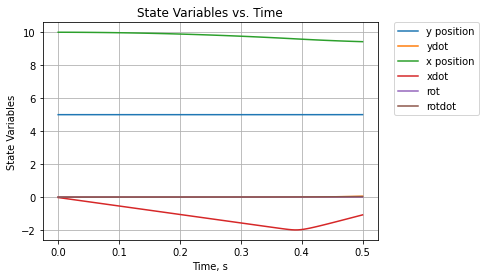

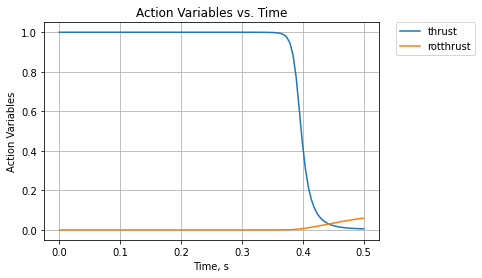

- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
[26] loss: 115.060


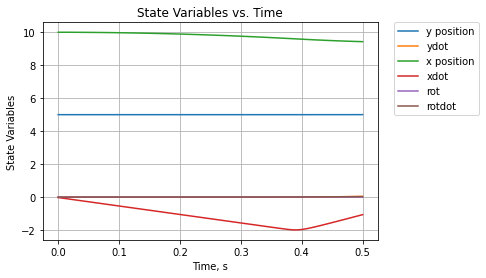

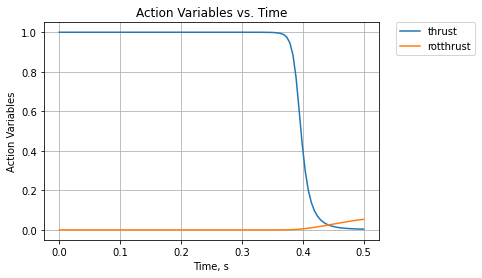

- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
[27] loss: 115.050


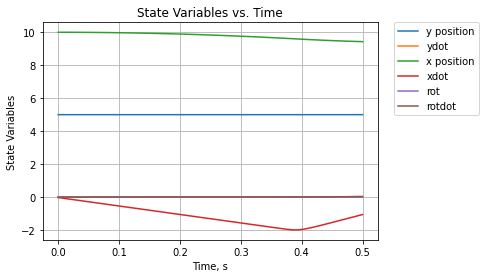

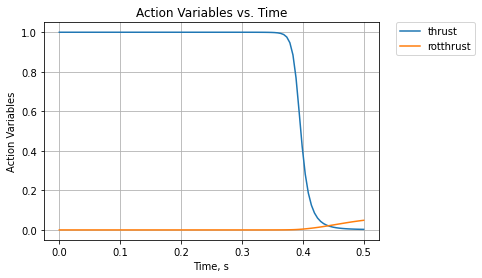

- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
[28] loss: 115.043


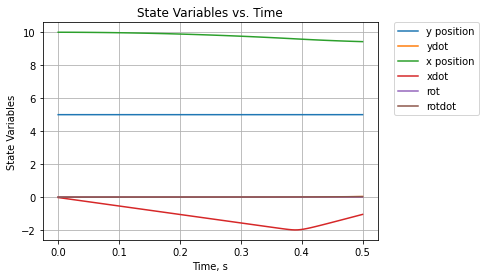

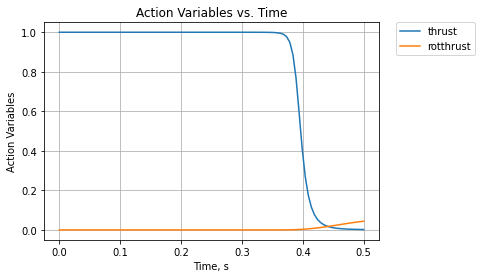

- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
[29] loss: 115.037


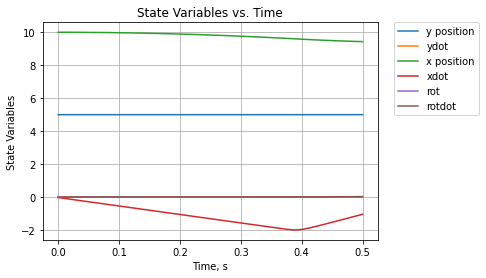

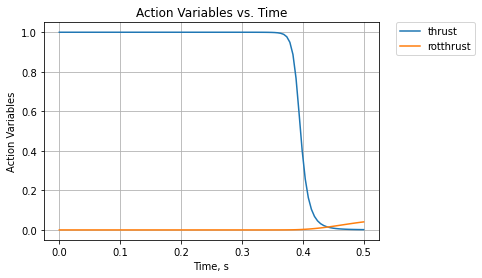

- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
[30] loss: 115.032


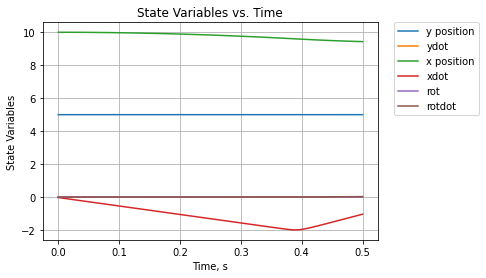

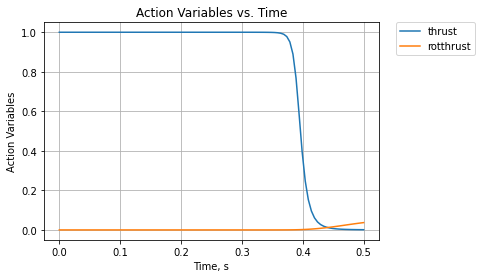

- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
[31] loss: 115.027


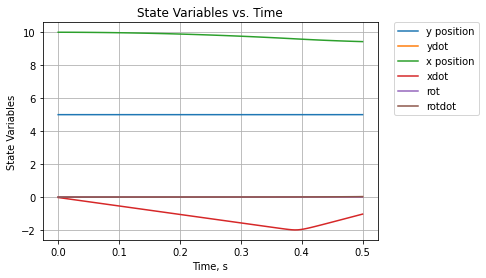

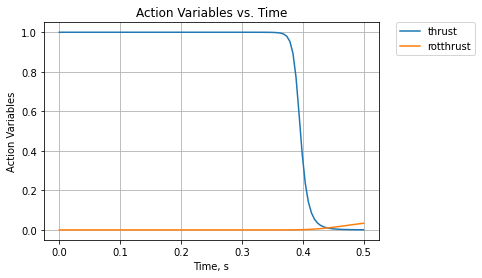

- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
[32] loss: 115.023


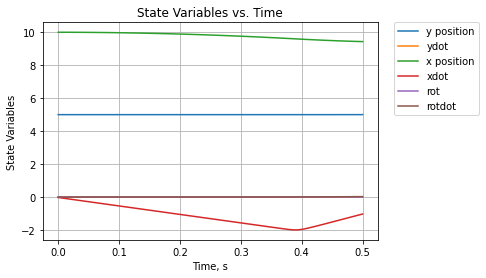

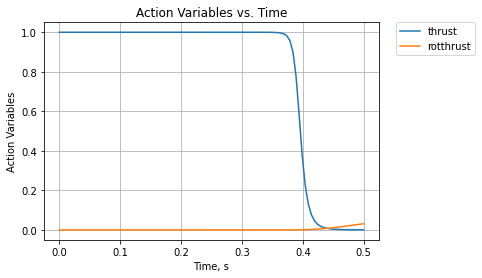

- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
[33] loss: 115.018


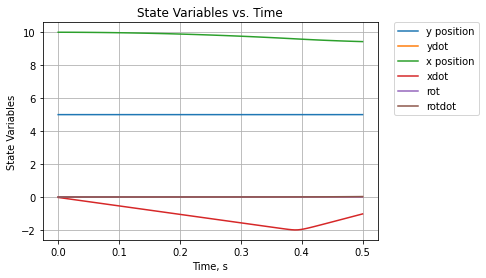

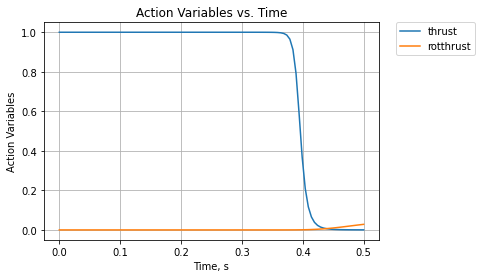

- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
[34] loss: 115.015


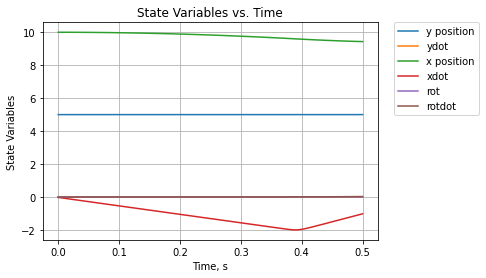

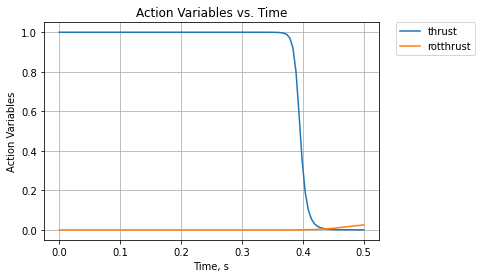

- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
[35] loss: 115.011


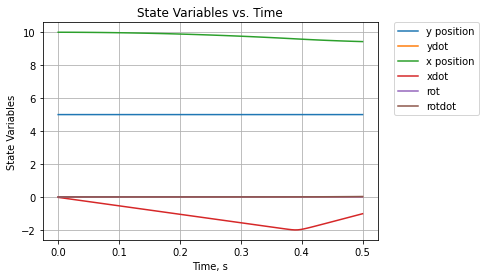

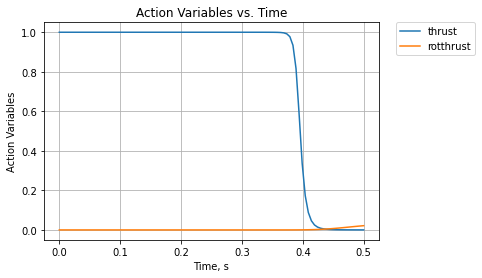

- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
[36] loss: 115.007


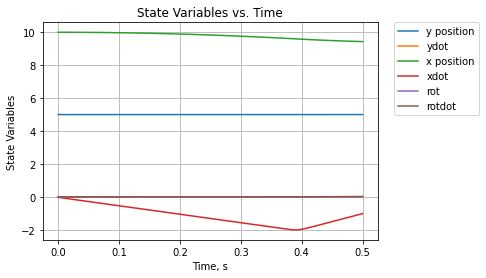

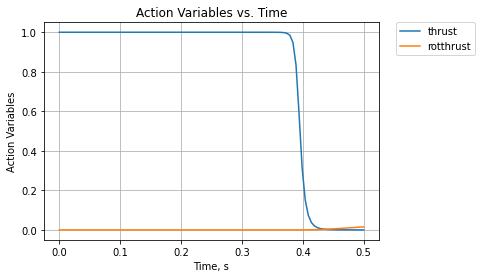

- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
[37] loss: 115.004


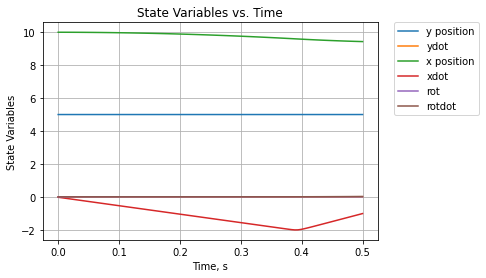

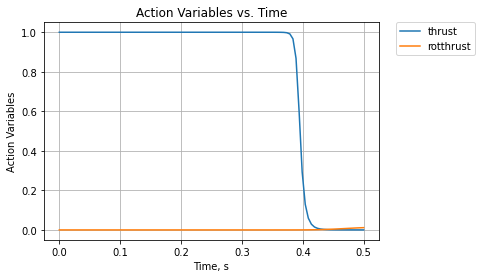

- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
[38] loss: 115.001


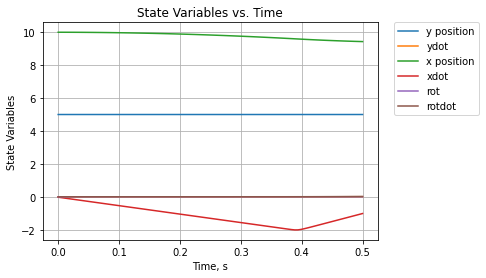

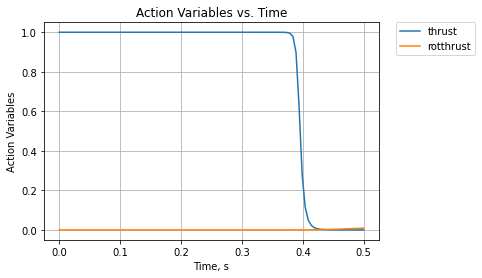

- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
[39] loss: 114.999


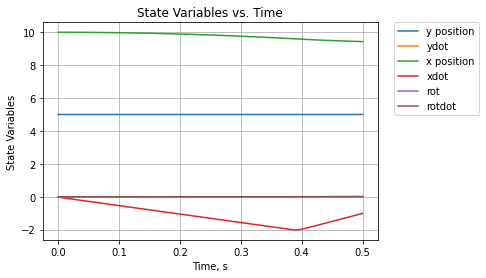

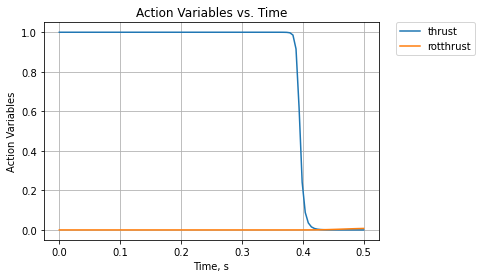

- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
[40] loss: 114.997


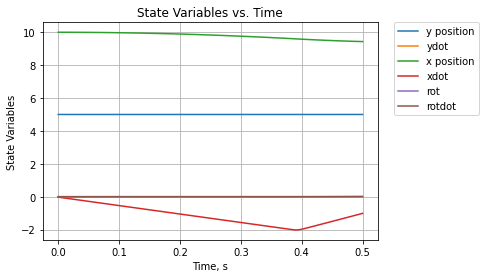

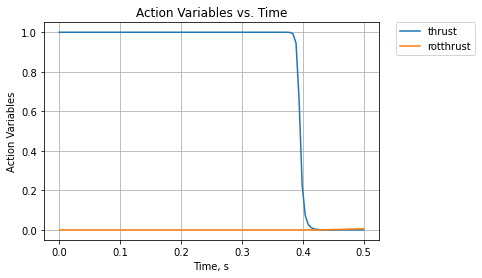

In [ ]:
# Now it's time to run the code!
T = 100  # number of time steps
dim_input = 6  # state space dimensions
dim_hidden = 9  # latent dimensions
dim_output = 3  # action space dimensions
d = Dynamics()  # define dynamics
c = Controller(dim_input, dim_hidden, dim_output)  # define controller
s = Simulation(c, d, T)  # define simulation
o = Optimize(s)  # define optimizer
o.train(40)  # solve the optimization problem

**Result**

From the graph we can see that the rocket landing discplacent is plotted.

The result is converging as iterations go on increasing. Thereby, we can say that neural network optimisation is successful for rocket landing program.
